# **Homework-2**

**Name:** Pavan Pandya

**Email:** pnpandya@iu.edu

## **Import Libraries**

In [1]:
!pip install librosa

In [2]:
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import librosa
import IPython.display as ipd
import soundfile as sf

In [3]:
# Set the seed for random number generators
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# If using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # To ensure deterministic behavior
    torch.backends.cudnn.benchmark = False

## **Get data from Gdrive**

In [4]:
# import shutil
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive/')

# # Define the data directory path
# data_dir = '/content/data/'

# # Delete the data directory if it exists
# if os.path.exists(data_dir):
#     shutil.rmtree(data_dir)

# # Unzip the file into the data directory
# !unzip "/content/drive/MyDrive/DLS/Homework-2/data.zip" -d "/content/data/"

## **Preparing Data for Q1 & Q2**

In [5]:
# Set the device to use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Ensure the model folder exist
model_dir = "/kaggle/working/model/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Ensure the output folder exists
output_dir = '/kaggle/working/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [86]:
# Load and preprocess data
def load_and_preprocess(file_path):
    s, sr = librosa.load(file_path, sr=None)
    S = np.abs(librosa.stft(s, n_fft=1024, hop_length=512))
    return S.T, sr

In [87]:
# Load training data
X, sr = load_and_preprocess('/kaggle/input/assignment-2-dataset/train_dirty_male.wav')
S, _ = load_and_preprocess('/kaggle/input/assignment-2-dataset/train_clean_male.wav')

In [88]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
S_tensor = torch.FloatTensor(S)

In [89]:
print("Shape of |S|:", S_tensor.shape)
print("Shape of |X|:", X_tensor.shape)

Shape of |S|: torch.Size([2459, 513])
Shape of |X|: torch.Size([2459, 513])


In [90]:
# Load validation data
x_val, sr_val = librosa.load('/kaggle/input/assignment-2-dataset/test_x_01.wav', sr=None)
X_val = np.abs(librosa.stft(x_val, n_fft=1024, hop_length=512))
X_val_tensor = torch.FloatTensor(X_val.T)

s_val_clean, _ = librosa.load('/kaggle/input/assignment-2-dataset/test_s_01.wav', sr=sr_val)

In [91]:
# Utility function for SNR calculation
def calculate_snr(clean_signal, denoised_signal):
    numerator = np.sum(clean_signal**2)
    denominator = np.sum((clean_signal - denoised_signal)**2) + 1e-20
    snr = 10 * np.log10(numerator / denominator)
    return snr

## **Problem-1: Speech Deniosing Using Deep Learning [3 Points]**

**Keywords:** Speech Denoising and Source Separation.

**Task:** Implement DNN with atleast two hidden layers.
- Build a simple deep learning based speech denoiser that takes a noisy speech spectrum (speech plus chips eating noise) and then produces a cleaned-up speech spectrum.

**Data:** `train_dirty_male.wav` and `train_clean_male.wav` are the noisy speech and its corresponding clean speech we are going to use for training the network.

**Training Steps:**

- Load the and convert them into spectrograms, which are matrix representation of the signals. To achieve this, we need to install `librosa` and use the following code:

  ```python
  !pip install librosa # in colab, you’ll need to install this
  import librosa
  s, sr=librosa.load(‘train_clean_male.wav’, sr=None)
  S=librosa.stft(s, n_fft=1024, hop_length=512)
  sn, sr=librosa.load(‘train_dirty_male.wav’, sr=None)
  X=librosa.stft(sn, n_fft=1024, hop_length=512)
  ```

- This will give us two matrices ${S}$ and ${X}$ of size `513 X 2459`. This procedure is called `Short-Time Fourier Transform`.

- Then, we need to take their magnitudes by using `np.abs()` or any suitable methods. Let's call them ${|S|}$ and ${|X|}$.

- Train a fully-connected DNN - Experiment with `# of hidden layers, activation function and initialization scheme`. The `input` to the network is a column vector of ${|X|}$ (a 513-dim vector) and the `target` is its corresponding one in ${|S|}$. Also, use `mini-batching`.

- Network should predict `non-negative magnitudes` as output.

**Testing Steps:**

- `test_01_x.wav` is the noisy signal for validation. Load them and apply the `Short-Time Fourier Transform` (STFT) as before.

- Feed the magnitude spectra of this test mixture ${|X_{\text{test}}|}$ to the network and predict their clean magnitude spectra $|\hat{S}_{\text{test}}|$.

- **Note:** We can recover the speech spectrogram of the test signal using `Hadamard Product`.

$$
\hat{S} = \frac{X_{\text{test}}}{|X_{\text{test}}|} \odot |\hat{S}_{\text{test}}| \tag{1}
$$

which means you take the phase information of the input noisy signal $\frac{X_{\text{test}}}{|X_{\text{test}}|}$ and use that to recover the clean speech. $\odot$ stands for the Hadamard product and the division is element-wise, too.

- Recover the time domain speech signal by applying an inverse-STFT on $\hat{S}_{\text{test}}$, which will give us a vector. Let's call this cleanedd-up test speech signal $\hat{s}_{\text{test}}$.

- Then, calculate Signal-to-Noise Ratio (SNR) comparing it with the ground truth speech using below code:

    ```python
    librosa.output.write_wav(‘test_s_01_recons.wav’, sh_test, sr)
    
    or
    
    import soundfile as sf
    sf.write(‘test_s_01_recons.wav’, sh_test, sr)
    ```
- We can compute SNR if we know the ground-truth source. Load `test_01_s.wav`. This is the ground-truth clean signal buried in `test_01_x.wav`. Compute the SNR of the predicted validation signal by comparing it to `test_01_s.wav`, but do not include this example to your training process. Once the training process is done, or even in the middle of training epochs, you apply your model to this validation example, and compute the SNR value. That way, you can simulate the testing environment, although it doesn’t guarantee that the model will work well on the test example, because the validation example can be different from the test set. This approach is related to the `early stopping technique` explained in `M03 S37`. Use this validation signal to prevent overfitting. By the way, SNR is defined as follows:

$$
\text{SNR} = 10 \log_{10} \left( \frac{\sum_t s^2(t)}{\sum_t \left( s(t) - \hat{s}(t) \right)^2} \right) \tag{2}
$$

where ${s(t)}$ and $\hat{s(t)}$ are the ground-truth clean speech and the recovered one in the time domain, respectively. Be careful with the division and logarithm: you don’t want your denominator to be zero or anything inside the log function to be zero. Adding a very small number, e.g., ${1 \times e^{-20}}$, is a good idea to prevent it.

**Outcome:** Do the same testing procedure for `test_02_x.wav`. Grading will be based on the denoised version of `test_02_x.wav` and Submit the audio file.



In [92]:
# Define the DNN model
class SpeechDenoiserDNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SpeechDenoiserDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

In [93]:
# Initialize model, loss function, and optimizer
input_size = S.shape[1]
hidden_size1 = 512
hidden_size2 = 512
output_size = S.shape[1]
learning_rate = 0.001

In [94]:
q1_model = SpeechDenoiserDNN(input_size, hidden_size1, hidden_size2, output_size)
q1_criterion = nn.MSELoss()
q1_optimizer = optim.Adam(q1_model.parameters(), lr=learning_rate)

In [95]:
# Training loop
num_epochs = 300
batch_size = 64
patience = 10  # for early stopping

In [96]:
# Training
q1_best_snr = float('-inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    q1_model.train()
    total_loss = 0
    num_batches = X_tensor.shape[0] // batch_size

    # Shuffle data
    indices = torch.randperm(X_tensor.shape[0])
    X_shuffled = X_tensor[indices]
    S_shuffled = S_tensor[indices]

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        batch_X = X_shuffled[start_idx:end_idx]
        batch_S = S_shuffled[start_idx:end_idx]

        q1_optimizer.zero_grad()
        outputs = q1_model(batch_X)
        loss = q1_criterion(outputs, batch_S)
        loss.backward()
        q1_optimizer.step()

        total_loss += loss.item()

    # Validation
    q1_model.eval()
    with torch.no_grad():
        S_hat_val = q1_model(X_val_tensor).numpy().T
        X_val_complex = librosa.stft(x_val, n_fft=1024, hop_length=512)
        S_hat_val_full = X_val_complex / np.abs(X_val_complex) * S_hat_val
        s_hat_val = librosa.istft(S_hat_val_full, hop_length=512, length=len(x_val))
        snr_val = calculate_snr(s_val_clean, s_hat_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/num_batches:.4f}, Validation SNR: {snr_val:.2f} dB')

    # Early stopping
    if snr_val > q1_best_snr:
        q1_best_snr = snr_val
        model_dir = '/kaggle/working/model'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(q1_model.state_dict(), os.path.join(model_dir, 'q1_best_model.pth'))
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

Epoch [1/300], Loss: 0.0568, Validation SNR: 2.88 dB
Epoch [2/300], Loss: 0.0277, Validation SNR: 3.87 dB
Epoch [3/300], Loss: 0.0186, Validation SNR: 4.94 dB
Epoch [4/300], Loss: 0.0153, Validation SNR: 5.18 dB
Epoch [5/300], Loss: 0.0122, Validation SNR: 5.69 dB
Epoch [6/300], Loss: 0.0104, Validation SNR: 6.22 dB
Epoch [7/300], Loss: 0.0095, Validation SNR: 6.23 dB
Epoch [8/300], Loss: 0.0091, Validation SNR: 6.50 dB
Epoch [9/300], Loss: 0.0082, Validation SNR: 6.51 dB
Epoch [10/300], Loss: 0.0084, Validation SNR: 6.49 dB
Epoch [11/300], Loss: 0.0077, Validation SNR: 6.65 dB
Epoch [12/300], Loss: 0.0072, Validation SNR: 6.96 dB
Epoch [13/300], Loss: 0.0065, Validation SNR: 6.87 dB
Epoch [14/300], Loss: 0.0062, Validation SNR: 6.81 dB
Epoch [15/300], Loss: 0.0058, Validation SNR: 6.92 dB
Epoch [16/300], Loss: 0.0062, Validation SNR: 7.09 dB
Epoch [17/300], Loss: 0.0056, Validation SNR: 7.15 dB
Epoch [18/300], Loss: 0.0052, Validation SNR: 7.34 dB
Epoch [19/300], Loss: 0.0049, Validat

In [97]:
# Calculate Best Validation SNR
print(f"Best Validation SNR: {q1_best_snr:.2f} dB")

Best Validation SNR: 7.96 dB


In [98]:
# Function to denoise a test file
def denoise_test_file_q1(q1_model, file_path):
    x_test, sr = librosa.load(file_path, sr=None)
    X_test = np.abs(librosa.stft(x_test, n_fft=1024, hop_length=512))
    X_test_tensor = torch.FloatTensor(X_test.T)

    q1_model.eval()
    with torch.no_grad():
        S_hat_test = q1_model(X_test_tensor).numpy().T

    # Reconstruct using phase of the original noisy signal
    X_test_complex = librosa.stft(x_test, n_fft=1024, hop_length=512)
    S_hat = X_test_complex / np.abs(X_test_complex) * S_hat_test
    s_hat = librosa.istft(S_hat, hop_length=512, length=len(x_test))

    return s_hat, sr

In [99]:
# Process and save test files
for test_file in ['test_x_01', 'test_x_02']:
    s_hat, sr = denoise_test_file_q1(q1_model, f'/kaggle/input/assignment-2-dataset/{test_file}.wav')
    output_file = f'/kaggle/working/output/q1_{test_file.replace("x", "s")}_recons.wav'
    sf.write(output_file, s_hat, sr)

    # Calculate SNR for test_01
    if test_file == 'test_x_01':
        s_noisy , _ = librosa.load('/kaggle/input/assignment-2-dataset/test_x_01.wav', sr=None)
        s_clean, _ = librosa.load('/kaggle/input/assignment-2-dataset/test_s_01.wav', sr=None)
        snr = calculate_snr(s_clean, s_noisy)
        print(f"SNR for {test_file}: {snr:.2f} dB")

print("Denoising complete. Output files saved in the specified directory.")

SNR for test_x_01: 13.23 dB
Denoising complete. Output files saved in the specified directory.


In [100]:
print("Original Test Audio File: test_x_01.wav")
ipd.Audio("/kaggle/input/assignment-2-dataset/test_x_01.wav")

Original Test Audio File: test_x_01.wav


In [101]:
print("Reconstructed Audio File: q1_test_s_01_recons.wav")
ipd.Audio("/kaggle/working/output/q1_test_s_01_recons.wav")

Reconstructed Audio File: q1_test_s_01_recons.wav


In [102]:
print("Original Test Audio File: test_x_02.wav")
ipd.Audio("/kaggle/input/assignment-2-dataset/test_x_02.wav")

Original Test Audio File: test_x_02.wav


In [103]:
print("Reconstructed Audio File: q1_test_s_02_recons.wav")
ipd.Audio("/kaggle/working/output/q1_test_s_02_recons.wav")

Reconstructed Audio File: q1_test_s_02_recons.wav


## **Problem 2: Speech Denoising Using 1D CNN [4 points]**

**Keywords:** 1D CNN, STFT magnitude domain, Speech Denoising

**Task:** Implement a 1D CNN that performs speech denoising in the STFT magnitude domain.

**Data:** Same as Problem 1 - `train_dirty_male.wav` and `train_clean_male.wav`

**Training Steps:**

1. Install and load librosa as in Problem 1.

2. Obtain magnitude spectrograms |X| and |S| using STFT:

   ```python
   import librosa
   import numpy as np

   s, sr = librosa.load('train_clean_male.wav', sr=None)
   S = np.abs(librosa.stft(s, n_fft=1024, hop_length=512))
   
   sn, sr = librosa.load('train_dirty_male.wav', sr=None)
   X = np.abs(librosa.stft(sn, n_fft=1024, hop_length=512))
   ```

3. Transpose matrices for CNN input: |X|⊤ and |S|⊤

4. Design 1D CNN architecture:
   - Input shape: [B × 1 × 1 × 513] (B = batch size)
   - Kernel size: 1 × D or D (depending on implementation)
   - First layer output: [B × K × 1 × (513 - D + 1)] (K = number of kernels)
   - Final output: [B × 513] (clean magnitude spectra approximation)

5. Implement CNN layers:
   - Use few kernels and hidden layers
   - Apply striding (>1) to reduce dimensionality after each CNN layer
   - Consider maxpooling with striding
   - Flatten last feature map and add linear layer to reduce to 513 dimensions
   - Apply activation functions at every layer, including the last

6. Train the model:
   - Use mini-batching
   - Experiment with various optimization techniques

**Testing Steps:**

1. Use the same test signal as in Problem 1 (`test_01_x.wav`).

2. Apply STFT and obtain magnitude spectrogram for the test signal.

3. Feed the test magnitude spectrogram through the trained 1D CNN.

4. Reconstruct the time-domain signal using the phase of the original noisy signal (as in Problem 1).

5. Compute SNR using the same method as in Problem 1.

6. Apply the same procedure to `test_02_x.wav`.

**Outcome:** Submit the denoised version of `test_02_x.wav`.

**Important Considerations:**

- Avoid zero-padding in CNN layers
- Be careful with dimensionality management, especially for the final FC layer
- The CNN operates along the frequency axis of the spectrogram
- Adjust stride and pooling to manage feature map size effectively

$$
\text{SNR} = 10 \log_{10} \left( \frac{\sum_t s^2(t)}{\sum_t \left( s(t) - \hat{s}(t) \right)^2} \right) \tag{1}
$$

Where s(t) is the ground-truth clean speech and ŝ(t) is the recovered speech in the time domain.

In [105]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
S_tensor = torch.FloatTensor(S)

In [106]:
print("Shape of |S|:", S_tensor.shape)
print("Shape of |X|:", X_tensor.shape)

Shape of |S|: torch.Size([2459, 513])
Shape of |X|: torch.Size([2459, 1, 513])


In [107]:
# Define the 1D CNN model
class SpeechDenoiser1DCNN(nn.Module):
    def __init__(self, input_size):
        super(SpeechDenoiser1DCNN, self).__init__()
        # CNN operates along the frequency axis of the spectrogram
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1)
        self.fc = nn.Linear(121 * (input_size // 4), input_size) # 128 * 121 = 15488 --> Final Shape (15488, 513)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.leaky_relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc(x))  # Ensure non-negative output
        return x

In [108]:
# Initialize model, loss function, and optimizer
learning_rate = 0.001

q2_model = SpeechDenoiser1DCNN(S.shape[1])
q2_criterion = nn.MSELoss()
q2_optimizer = optim.Adam(q2_model.parameters(), lr=learning_rate)

In [109]:
# Training loop
num_epochs = 300
batch_size = 64
patience = 10  # for early stopping

# Load validation data
X_val_tensor = X_val_tensor.unsqueeze(1)

q2_best_snr = float('-inf')
epochs_without_improvement = 0

In [110]:
for epoch in range(num_epochs):
    q2_model.train()
    total_loss = 0
    num_batches = X_tensor.shape[0] // batch_size

    # Shuffle data
    indices = torch.randperm(X_tensor.shape[0])
    X_shuffled = X_tensor[indices]
    S_shuffled = S_tensor[indices]

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        batch_X = X_shuffled[start_idx:end_idx]
        batch_S = S_shuffled[start_idx:end_idx]

        q2_optimizer.zero_grad()
        outputs = q2_model(batch_X)
        loss = q2_criterion(outputs, batch_S)
        loss.backward()
        q2_optimizer.step()

        total_loss += loss.item()

    # Validation
    q2_model.eval()
    with torch.no_grad():
        S_hat_val = q2_model(X_val_tensor).squeeze(1).numpy().T
        X_val_complex = librosa.stft(x_val, n_fft=1024, hop_length=512)
        S_hat_val_full = X_val_complex / np.abs(X_val_complex) * S_hat_val
        s_hat_val = librosa.istft(S_hat_val_full, hop_length=512, length=len(x_val))
        snr_val = calculate_snr(s_val_clean, s_hat_val)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / num_batches:.4f}, Validation SNR: {snr_val:.2f} dB')

    # Early stopping
    if snr_val > q2_best_snr:
        q2_best_snr = snr_val
        model_dir = '/kaggle/working/model'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(q2_model.state_dict(), os.path.join(model_dir, 'q2_best_model.pth'))
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

Epoch [1/300], Loss: 0.0622, Validation SNR: 3.24 dB
Epoch [2/300], Loss: 0.0261, Validation SNR: 5.13 dB
Epoch [3/300], Loss: 0.0173, Validation SNR: 6.01 dB
Epoch [4/300], Loss: 0.0140, Validation SNR: 6.51 dB
Epoch [5/300], Loss: 0.0124, Validation SNR: 6.77 dB
Epoch [6/300], Loss: 0.0113, Validation SNR: 7.24 dB
Epoch [7/300], Loss: 0.0115, Validation SNR: 6.69 dB
Epoch [8/300], Loss: 0.0109, Validation SNR: 7.54 dB
Epoch [9/300], Loss: 0.0104, Validation SNR: 7.55 dB
Epoch [10/300], Loss: 0.0098, Validation SNR: 7.50 dB
Epoch [11/300], Loss: 0.0095, Validation SNR: 7.49 dB
Epoch [12/300], Loss: 0.0093, Validation SNR: 7.72 dB
Epoch [13/300], Loss: 0.0093, Validation SNR: 7.81 dB
Epoch [14/300], Loss: 0.0094, Validation SNR: 7.67 dB
Epoch [15/300], Loss: 0.0092, Validation SNR: 7.64 dB
Epoch [16/300], Loss: 0.0091, Validation SNR: 7.85 dB
Epoch [17/300], Loss: 0.0090, Validation SNR: 7.83 dB
Epoch [18/300], Loss: 0.0090, Validation SNR: 7.89 dB
Epoch [19/300], Loss: 0.0087, Validat

In [111]:
# Best Validation SNR
print(f"Best Validation SNR: {q2_best_snr:.2f} dB")

Best Validation SNR: 8.10 dB


In [112]:
# Function to denoise a test file
def denoise_test_file_q2(q2_model, file_path):
    x_test, sr = librosa.load(file_path, sr=None)
    X_test = np.abs(librosa.stft(x_test, n_fft=1024, hop_length=512))
    X_test_tensor = torch.FloatTensor(X_test.T).unsqueeze(1)

    q2_model.eval()
    with torch.no_grad():
        S_hat_test = q2_model(X_test_tensor).squeeze(1).numpy().T

    # Reconstruct using phase of the original noisy signal
    X_test_complex = librosa.stft(x_test, n_fft=1024, hop_length=512)
    S_hat = X_test_complex / np.abs(X_test_complex) * S_hat_test
    s_hat = librosa.istft(S_hat, hop_length=512, length=len(x_test))

    return s_hat, sr

In [113]:
# Process and save test files
for test_file in ['test_x_01', 'test_x_02']:
    s_hat, sr = denoise_test_file_q2(q2_model, f'/kaggle/input/assignment-2-dataset/{test_file}.wav')
    output_file = f'/kaggle/working/output/q2_{test_file.replace("x", "s")}_recons.wav'
    sf.write(output_file, s_hat, sr)

    # Calculate SNR for test_01
    if test_file == 'test_x_01':
        s_noisy , _ = librosa.load('/kaggle/input/assignment-2-dataset/test_x_01.wav', sr=None)
        s_clean, _ = librosa.load('/kaggle/input/assignment-2-dataset/test_s_01.wav', sr=None)
        snr = calculate_snr(s_clean, s_noisy)
        print(f"SNR for {test_file}: {snr:.2f} dB")

print("Denoising complete. Output files saved in the specified directory.")

SNR for test_x_01: 13.23 dB
Denoising complete. Output files saved in the specified directory.


In [114]:
print("Original Test Audio File: test_x_01.wav")
ipd.Audio("/kaggle/input/assignment-2-dataset/test_x_01.wav")

Original Test Audio File: test_x_01.wav


In [115]:
print("Reconstructed Audio File: q2_test_s_01_recons.wav")
ipd.Audio("/kaggle/working/output/q2_test_s_01_recons.wav")

Reconstructed Audio File: q2_test_s_01_recons.wav


In [116]:
print("Original Test Audio File: test_x_02.wav")
ipd.Audio("/kaggle/input/assignment-2-dataset/test_x_02.wav")

Original Test Audio File: test_x_02.wav


In [117]:
print("Reconstructed Audio File: q2_test_s_02_recons.wav")
ipd.Audio("/kaggle/working/output/q2_test_s_02_recons.wav")

Reconstructed Audio File: q2_test_s_02_recons.wav


## **Problem 3: Data Augmentation [4 points]**

**Dataset: CIFAR-10**

- 10 visual object classes
- Download from [https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html)
- Set aside 5,000 training examples for validation

**Baseline CNN Classifier**

1. Preprocess images:
   - Reshape to 32 x 32 x 3 tensors
   - Convert 8-bit integers (0-255) to floats (0-1)
   - Rescale to [-1, 1] range

2. Architecture:
   - Conv2D: 10 kernels, 5x5x3, stride=1
   - MaxPooling: 2x2, stride=2
   - Conv2D: 10 kernels, 5x5x10, stride=1
   - MaxPooling: 2x2, stride=2
   - Fully-connected: [flattened] x 20
   - Fully-connected: 20 x 10
   - Softmax output

3. Training:
   - ReLU activation
   - He initialization
   - Adam optimizer (learning rate = 0.001)
   - Record validation accuracy per epoch
   - Plot validation accuracy over epochs

**Augmented Dataset Classifier**

1. Create 4 augmented datasets:
   - #1: Brighten by 10% (clip at 1.0)
   - #2: Darken by 10%
   - #3: Horizontal flip
   - #4: Original images

2. Merge augmented datasets:
   - 45,000 original + 135,000 augmented = 180,000 total
   - Rescale to [-1, 1] range
   - Visualize samples to verify augmentations

3. Train new network:
   - Use same architecture as baseline
   - Train on full augmented dataset
   - Record validation accuracy per epoch

**Comparison**

- Plot validation accuracy curves for baseline and augmented models
- Run for 200 epochs
- Analyze improvement from data augmentation

**Code Snippets**

```python
# Brightness augmentation
augmented_1 = np.minimum(1.1 * X, 1)

# Darkness augmentation  
augmented_2 = 0.9 * X

# Horizontal flip
augmented_3 = X[:, :, ::-1, :]

# Merge datasets
augmented_full = np.concatenate([X, augmented_1, augmented_2, augmented_3], axis=0)

# Rescale to [-1, 1]
augmented_full = (augmented_full - 0.5) * 2
```

**Key Points**

- Data augmentation increases dataset size 4x
- Maintain original labels for augmented images
- Visualize augmented images to verify correctness
- Compare validation performance between baseline and augmented models
- No need to run final test set evaluation

In [17]:
# CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(10 * 5 * 5, 20)
        self.fc2 = nn.Linear(20, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
# Training function
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    val_accuracies = []
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}, Val Accuracy: {val_accuracy:.2f}%')

        # Save the model if it's the best so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)

    print(f"Model saved with validation accuracy: {best_val_accuracy:.2f}%")

    return val_accuracies

In [9]:
# Visualization function
def imshow(img, title):
    img = img/2 + 0.5 # UnNormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

### **Part 1: Baseline Model**

In [10]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # This scales to [-1, 1]
])

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49214245.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [12]:
# Set aside 5,000 training examples for validation
train_size = len(trainset) - 5000
val_size = 5000
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [13]:
# Create data loaders
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

In [14]:
next(iter(trainloader))[0].shape

torch.Size([64, 3, 32, 32])

In [15]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Set up model save path
model_save_dir = '/kaggle/working/model'
baseline_model_save_path = os.path.join(model_save_dir, 'q3_baseline_model.pth')

In [17]:
# Train the model
num_epochs = 200
baseline_val_accuracies = train_model(model, trainloader, valloader, criterion, optimizer, num_epochs, baseline_model_save_path)

Epoch 1, Loss: 1.930, Val Accuracy: 38.62%
Epoch 2, Loss: 1.557, Val Accuracy: 44.96%
Epoch 3, Loss: 1.434, Val Accuracy: 47.08%
Epoch 4, Loss: 1.365, Val Accuracy: 50.50%
Epoch 5, Loss: 1.305, Val Accuracy: 52.42%
Epoch 6, Loss: 1.251, Val Accuracy: 54.14%
Epoch 7, Loss: 1.215, Val Accuracy: 54.96%
Epoch 8, Loss: 1.173, Val Accuracy: 56.54%
Epoch 9, Loss: 1.146, Val Accuracy: 56.48%
Epoch 10, Loss: 1.121, Val Accuracy: 58.26%
Epoch 11, Loss: 1.099, Val Accuracy: 58.78%
Epoch 12, Loss: 1.086, Val Accuracy: 59.42%
Epoch 13, Loss: 1.065, Val Accuracy: 58.82%
Epoch 14, Loss: 1.052, Val Accuracy: 59.34%
Epoch 15, Loss: 1.034, Val Accuracy: 60.54%
Epoch 16, Loss: 1.026, Val Accuracy: 60.98%
Epoch 17, Loss: 1.015, Val Accuracy: 61.96%
Epoch 18, Loss: 1.006, Val Accuracy: 61.02%
Epoch 19, Loss: 0.996, Val Accuracy: 60.72%
Epoch 20, Loss: 0.989, Val Accuracy: 61.72%
Epoch 21, Loss: 0.982, Val Accuracy: 61.74%
Epoch 22, Loss: 0.969, Val Accuracy: 62.02%
Epoch 23, Loss: 0.966, Val Accuracy: 62.0

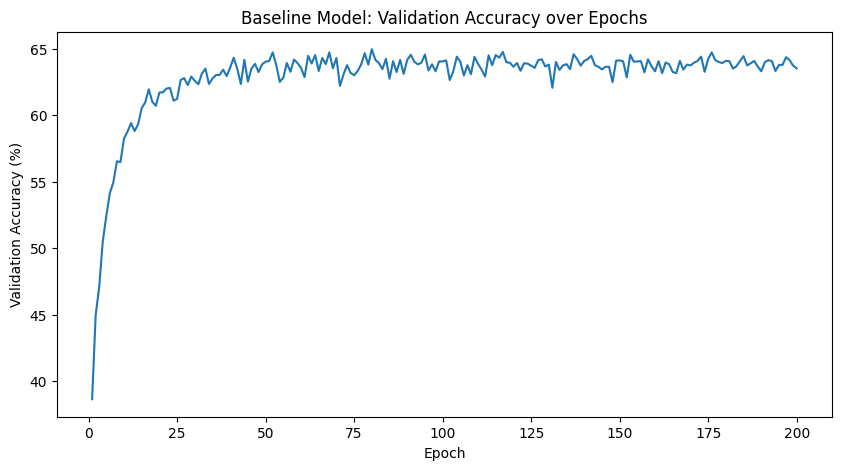

In [18]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), baseline_val_accuracies)
plt.title('Baseline Model: Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.show()

### **Part 2: Data Augmentation Model**

In [19]:
# Custom transforms for data augmentation
class BrightenImage(object):
    def __call__(self, img):
        return torch.clamp(1.1 * img, 0, 1)  # Brighten and clamp to [0, 1]

class DarkenImage(object):
    def __call__(self, img):
        return torch.clamp(0.9 * img, 0, 1)  # Darken and clamp to [0, 1]

In [20]:
# Normalization transformation to scale to [-1, +1] after augmentations
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Prepare transformation pipelines for each augmented dataset
transform_original = transforms.Compose([transforms.ToTensor(), normalize])  # Converts to [0, 1] and then normalizes to [-1, +1]
transform_brighten = transforms.Compose([transforms.ToTensor(), BrightenImage(), normalize])  # Apply brightening and then normalize
transform_darken = transforms.Compose([transforms.ToTensor(), DarkenImage(), normalize])  # Apply darkening and then normalize
transform_flip = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=1.0), normalize])  # Apply flipping and normalize

In [21]:
# Load the original CIFAR-10 dataset
trainset_original = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_original)

Files already downloaded and verified


In [22]:
# Create the three augmented datasets
trainset_brighten = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_brighten)
trainset_darken = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_darken)
trainset_flip = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_flip)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Merge the original and augmented datasets into one large dataset
augmented_trainset = torch.utils.data.ConcatDataset([trainset_original, trainset_brighten, trainset_darken, trainset_flip])
trainset, _ = torch.utils.data.random_split(augmented_trainset, [train_size*4, val_size*4])

In [25]:
# Print the total number of images in the trainset
print(f"Total number of images in the trainset: {len(trainset)}")

Total number of images in the trainset: 180000


**Note:** I am using the same valloader defined above and use in the part-a.

In [26]:
# Create data loaders
batch_size = 64
augmented_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [27]:
# Create DataLoaders for each augmented dataset
bright_loader = torch.utils.data.DataLoader(trainset_brighten, batch_size=1, shuffle=False)
dark_loader = torch.utils.data.DataLoader(trainset_darken, batch_size=1, shuffle=False)
flip_loader = torch.utils.data.DataLoader(trainset_flip, batch_size=1, shuffle=False)
original_loader = torch.utils.data.DataLoader(trainset_original, batch_size=1, shuffle=False)

In [28]:
# Get images and labels
bright_image, _ = next(iter(bright_loader))
dark_image, _ = next(iter(dark_loader))
flip_image, _ = next(iter(flip_loader))
original_image, _ = next(iter(original_loader))

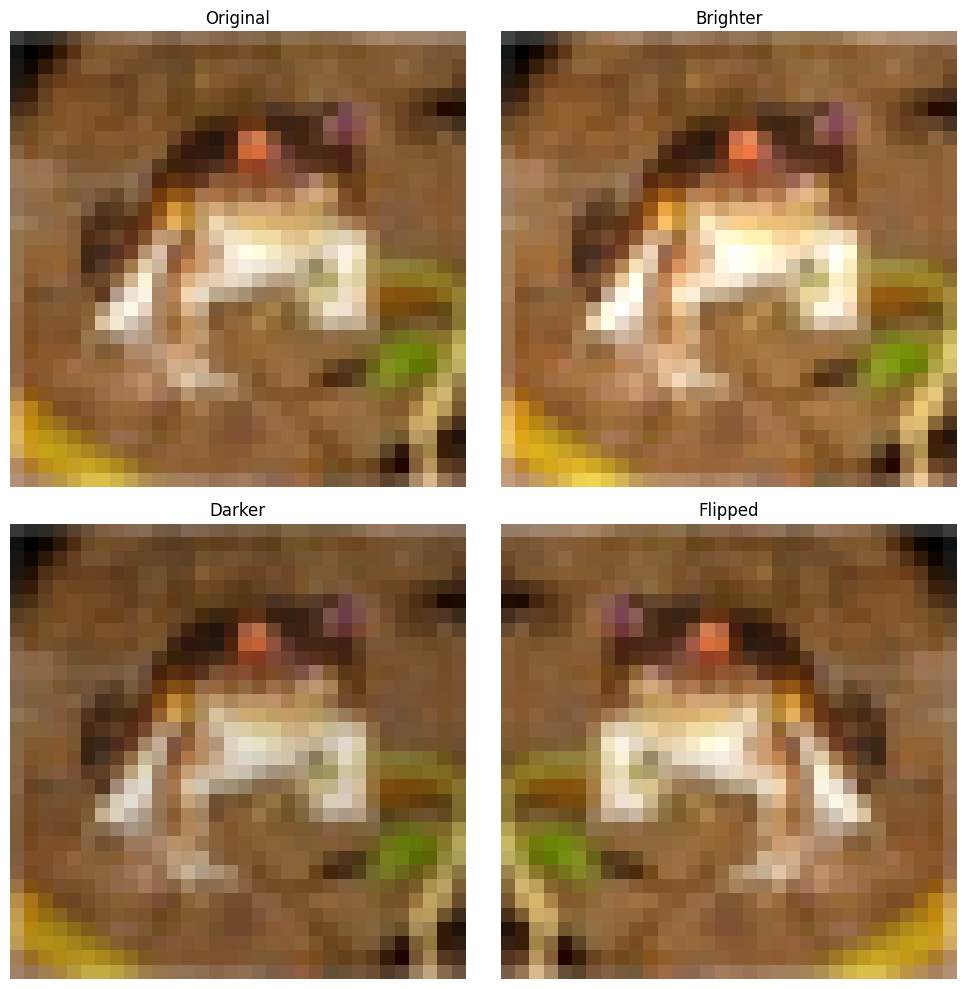

In [29]:
# Visualize a few augmented images
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
imshow(original_image[0], "Original")

plt.subplot(2, 2, 2)
imshow(bright_image[0], "Brighter")

plt.subplot(2, 2, 3)
imshow(dark_image[0], "Darker")

plt.subplot(2, 2, 4)
imshow(flip_image[0], "Flipped")

plt.tight_layout()
plt.show()

In [30]:
# Initialize a fresh model, loss function, and optimizer
augmented_model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(augmented_model.parameters(), lr=0.001)

In [31]:
# Set up model save path
augmented_model_save_path = os.path.join(model_save_dir, 'q3_augmented_model.pth')

In [32]:
# Train the model on augmented dataset
num_epochs = 200
augmented_val_accuracies = train_model(augmented_model, augmented_trainloader, valloader, criterion, optimizer, num_epochs, augmented_model_save_path)

Epoch 1, Loss: 1.565, Val Accuracy: 50.50%
Epoch 2, Loss: 1.259, Val Accuracy: 59.08%
Epoch 3, Loss: 1.133, Val Accuracy: 62.04%
Epoch 4, Loss: 1.064, Val Accuracy: 64.50%
Epoch 5, Loss: 1.021, Val Accuracy: 65.36%
Epoch 6, Loss: 0.991, Val Accuracy: 67.72%
Epoch 7, Loss: 0.970, Val Accuracy: 68.16%
Epoch 8, Loss: 0.953, Val Accuracy: 68.24%
Epoch 9, Loss: 0.941, Val Accuracy: 67.46%
Epoch 10, Loss: 0.929, Val Accuracy: 68.22%
Epoch 11, Loss: 0.919, Val Accuracy: 69.14%
Epoch 12, Loss: 0.912, Val Accuracy: 68.68%
Epoch 13, Loss: 0.906, Val Accuracy: 69.06%
Epoch 14, Loss: 0.898, Val Accuracy: 69.82%
Epoch 15, Loss: 0.890, Val Accuracy: 70.56%
Epoch 16, Loss: 0.885, Val Accuracy: 70.68%
Epoch 17, Loss: 0.881, Val Accuracy: 71.12%
Epoch 18, Loss: 0.875, Val Accuracy: 70.54%
Epoch 19, Loss: 0.872, Val Accuracy: 71.38%
Epoch 20, Loss: 0.866, Val Accuracy: 70.92%
Epoch 21, Loss: 0.866, Val Accuracy: 70.70%
Epoch 22, Loss: 0.861, Val Accuracy: 70.94%
Epoch 23, Loss: 0.858, Val Accuracy: 70.8

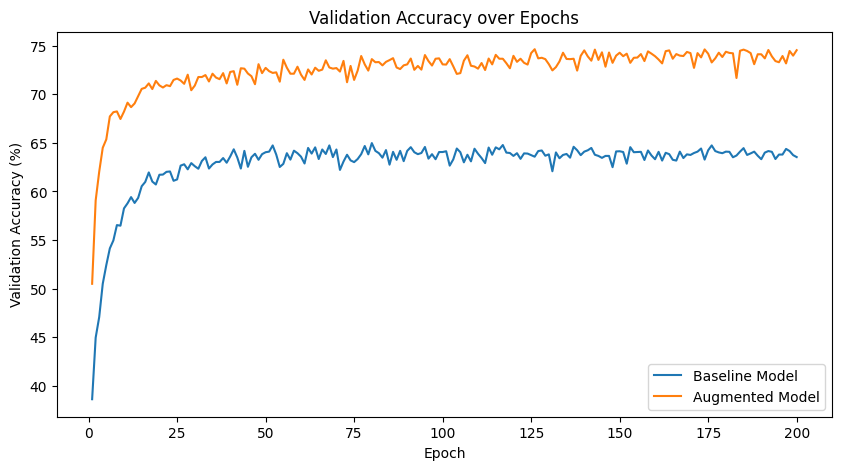

In [33]:
# Plot validation accuracy for both models
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), baseline_val_accuracies, label='Baseline Model')
plt.plot(range(1, num_epochs+1), augmented_val_accuracies, label='Augmented Model')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()

## **Problem 4: Self-Supervised Learning via Pretext Tasks [4 points]**

**Scenario:** CIFAR10 classification with limited labeled data (50 examples per class, 500 total)

**Pretext Task**

1. Set aside 500 examples from the training set
2. Use remaining 49,500 training examples as unlabeled data
3. Create three classes:
   - Class 0: Original unlabeled images
   - Class 1: Vertically flipped images
   - Class 2: 90-degree counter-clockwise rotated images
4. Train network:
   - Use same setup/architecture as Problem 3
   - Run about 100 epochs
   - Store model parameters

**Baseline Classifier**

1. Train from scratch on 500 CIFAR10 dataset
2. Use original 10-class classification
3. Use same architecture/setup as pretext task
4. Choose reasonable initializer (e.g., He initializer)
5. Use test set (10,000 examples) as validation set
6. Record accuracy values every 100 epochs

**Transfer Learning Task**

1. Train on same 500 CIFAR10 dataset
2. Reload weights from pretext network
3. Transfer all parameters except final softmax layer
4. Randomly initialize last layer with He initializer
5. Adjust learning rates:
   - Transferred layers: 1e-5 or 1e-6
   - Last softmax layer: 1e-3 (default)
6. Report test accuracy every 100 epochs

**Comparison**

1. Run both experiments for 10,000 epochs
2. Record validation (test) accuracy every 100 epochs
3. Draw two graphs comparing baseline and finetuning methods
4. Expect improvement from self-supervised features


In [7]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# Load CIFAR10 dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 48055847.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
# Create a subset with 50 examples per class (500 total)
indices = []
examples_per_class = 50
for class_id in range(10):
    class_indices = (torch.tensor(full_trainset.targets) == class_id).nonzero().squeeze()
    indices.extend(class_indices[-examples_per_class:].tolist())  # Take the last 50 examples of each class

In [10]:
# Create the subset
trainset = Subset(full_trainset, indices)

In [11]:
# Create DataLoader
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
print(f"Number of training examples: {len(trainset)}")

Number of training examples: 500


### **Pretext Task**

In [13]:
# Create the pretext dataset
class PretextDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset) * 3

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)
        img, _ = self.dataset[original_idx]
        
        if idx < len(self.dataset):
            # Class 0: Original image
            return img, 0
        elif idx < 2 * len(self.dataset):
            # Class 1: Vertically flipped image
            return transforms.functional.vflip(img), 1
        else:
            # Class 2: 90 degree counter-clockwise rotated image
            return transforms.functional.rotate(img, 90), 2

In [14]:
# Create the pretext dataset using the remaining 49,500 examples
remaining_indices = list(set(range(len(full_trainset))) - set(indices))
remaining_dataset = Subset(full_trainset, remaining_indices)
pretext_dataset = PretextDataset(remaining_dataset)
pretext_loader = DataLoader(pretext_dataset, batch_size=128, shuffle=True, num_workers=2)

In [15]:
# Number of Images in Pretext Dataset
print(f"Number of images in pretext_dataset: {len(pretext_dataset)}")

Number of images in pretext_dataset: 148500


In [18]:
q4_pretext_model = SimpleCNN(num_classes=3)

In [19]:
# Training setup
q4_pretext_model = q4_pretext_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(q4_pretext_model.parameters(), lr=0.001)

In [20]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    q4_pretext_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(pretext_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = q4_pretext_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(pretext_loader)
    epoch_acc = 100. * correct / total
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.2f}%')

print('Finished Training')

Epoch 1, Loss: 0.942, Accuracy: 53.66%
Epoch 2, Loss: 0.824, Accuracy: 61.43%
Epoch 3, Loss: 0.769, Accuracy: 65.14%
Epoch 4, Loss: 0.736, Accuracy: 67.26%
Epoch 5, Loss: 0.713, Accuracy: 68.43%
Epoch 6, Loss: 0.697, Accuracy: 69.30%
Epoch 7, Loss: 0.684, Accuracy: 69.99%
Epoch 8, Loss: 0.673, Accuracy: 70.65%
Epoch 9, Loss: 0.664, Accuracy: 71.02%
Epoch 10, Loss: 0.656, Accuracy: 71.43%
Epoch 11, Loss: 0.649, Accuracy: 71.85%
Epoch 12, Loss: 0.642, Accuracy: 72.06%
Epoch 13, Loss: 0.637, Accuracy: 72.50%
Epoch 14, Loss: 0.632, Accuracy: 72.63%
Epoch 15, Loss: 0.628, Accuracy: 72.76%
Epoch 16, Loss: 0.622, Accuracy: 73.01%
Epoch 17, Loss: 0.620, Accuracy: 73.25%
Epoch 18, Loss: 0.616, Accuracy: 73.48%
Epoch 19, Loss: 0.613, Accuracy: 73.59%
Epoch 20, Loss: 0.609, Accuracy: 73.89%
Epoch 21, Loss: 0.605, Accuracy: 73.99%
Epoch 22, Loss: 0.604, Accuracy: 74.08%
Epoch 23, Loss: 0.601, Accuracy: 74.17%
Epoch 24, Loss: 0.597, Accuracy: 74.37%
Epoch 25, Loss: 0.596, Accuracy: 74.49%
Epoch 26,

In [21]:
# Save the model
torch.save(q4_pretext_model.state_dict(), '/kaggle/working/model/q4_pretext_model.pth')
print('Model saved as q4_pretext_model.pth')

Model saved as q4_pretext_model.pth


### **Baseline Task**

In [23]:
# Create the test set (which we'll use as validation)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [24]:
# Use the existing SimpleCNN model
q4_baseline_model = SimpleCNN(num_classes=10)  # 10 classes for CIFAR10
q4_baseline_model = q4_baseline_model.to(device)

In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(q4_baseline_model.parameters(), lr=0.001)

In [27]:
# Training loop
num_epochs = 10000
baseline_accuracies = []
training_losses = []

for epoch in range(num_epochs):
    q4_baseline_model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = q4_baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(trainloader)
    training_losses.append(avg_train_loss)
    
    # Evaluate on test set (used as validation) every 100 epochs
    if (epoch + 1) % 100 == 0:
        q4_baseline_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = q4_baseline_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100 * correct / total
        baseline_accuracies.append(accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

print('Finished Training')

Epoch [100/10000], Training Loss: 0.5640, Validation Accuracy: 26.98%
Epoch [200/10000], Training Loss: 0.0565, Validation Accuracy: 27.40%
Epoch [300/10000], Training Loss: 0.0112, Validation Accuracy: 27.52%
Epoch [400/10000], Training Loss: 0.0040, Validation Accuracy: 27.57%
Epoch [500/10000], Training Loss: 0.0020, Validation Accuracy: 27.53%
Epoch [600/10000], Training Loss: 0.0011, Validation Accuracy: 27.57%
Epoch [700/10000], Training Loss: 0.0007, Validation Accuracy: 27.40%
Epoch [800/10000], Training Loss: 0.0005, Validation Accuracy: 27.59%
Epoch [900/10000], Training Loss: 0.0003, Validation Accuracy: 27.68%
Epoch [1000/10000], Training Loss: 0.0002, Validation Accuracy: 27.78%
Epoch [1100/10000], Training Loss: 0.0002, Validation Accuracy: 27.79%
Epoch [1200/10000], Training Loss: 0.0001, Validation Accuracy: 27.76%
Epoch [1300/10000], Training Loss: 0.0001, Validation Accuracy: 27.79%
Epoch [1400/10000], Training Loss: 0.0001, Validation Accuracy: 27.82%
Epoch [1500/100

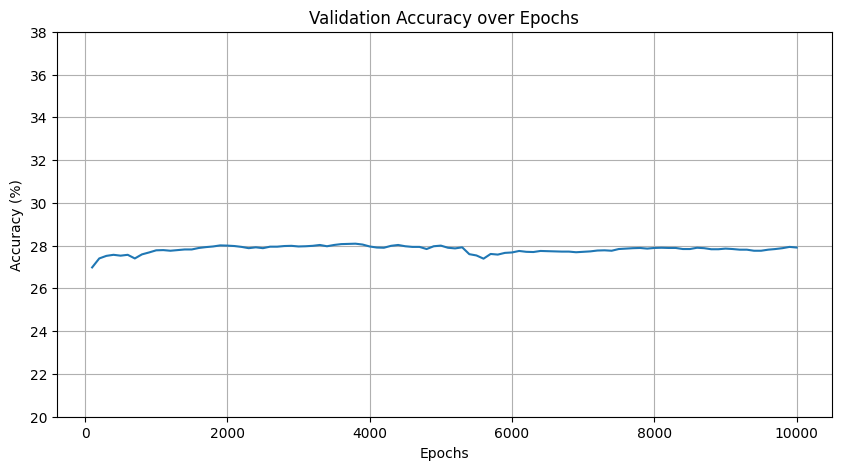

In [30]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs + 1, 100), baseline_accuracies)
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.yticks([i for i in range(20, 40, 2)])
plt.grid(True)
plt.show()

In [29]:
# Save the model
torch.save(q4_baseline_model.state_dict(), '/kaggle/working/model/q4_baseline_model.pth')
print('Model saved as q4_baseline_model.pth')

Model saved as q4_baseline_model.pth


### **Self Learning Task**

In [53]:
def load_pretrained_weights(model, pretrained_path):
    model.load_state_dict(torch.load(pretrained_path))
    model.fc2 = nn.Linear(20, 10)
    
    nn.init.kaiming_normal_(model.fc2.weight, nonlinearity='relu')
    if model.fc2.bias is not None:
        nn.init.constant_(model.fc2.bias, 0)

In [54]:
# Function to prepare the optimizer with different learning rates for layers
def create_optimizer(model):
    new_params = ['fc2.weight', 'fc2.bias']
    new_params_list = []
    old_params_list = []

    # Separate parameters for the classifier and other layers
    for name, param in model.named_parameters():
        if name in new_params:
            new_params_list.append(param)
        else:
            old_params_list.append(param)
    
    # Define optimizer with different learning rates
    optimizer = optim.Adam([
        {'params': old_params_list, 'lr': 1e-6},  # Small LR for pretrained layers
        {'params': new_params_list, 'lr': 0.001}  # Higher LR for new layers
    ])
    
    return optimizer

In [55]:
# Instantiate the model
transfer_model = SimpleCNN(num_classes=3) 

In [56]:
# Load pretrained weights and initialize new layers
load_pretrained_weights(transfer_model, '/kaggle/working/model/q4_pretext_model.pth')

/tmp/ipykernel_30/803301260.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_path))


In [57]:
transfer_model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

In [58]:
# Prepare optimizer with different learning rates
optimizer = create_optimizer(transfer_model)

In [59]:
# Function to train and validate the model
def train_model(model, train_loader, test_loader, optimizer, num_epochs=10000):
    criterion = nn.CrossEntropyLoss()
    finetuning_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase every 100 epochs
        if (epoch + 1) % 100 == 0:
            model.eval()
            correct, total = 0, 0
            running_val_loss = 0.0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    
                    # Compute validation loss
                    val_loss = criterion(outputs, labels)
                    running_val_loss += val_loss.item()

                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            # Calculate validation accuracy and average loss
            accuracy = 100 * correct / total
            avg_val_loss = running_val_loss / len(test_loader)

            # Print epoch information with loss and accuracy
            print(f'Epoch [{epoch+1}/{num_epochs}] | '
                  f'Training Loss: {avg_train_loss:.4f} | '
                  f'Validation Loss: {avg_val_loss:.4f} | '
                  f'Validation Accuracy: {accuracy:.2f}%')

            finetuning_accuracies.append(accuracy)

    print('Training complete')
    return finetuning_accuracies

In [60]:
# Train the model
finetuning_accuracies = train_model(transfer_model, trainloader, testloader, optimizer)

Epoch [100/10000] | Training Loss: 3.4372 | Validation Loss: 3.8613 | Validation Accuracy: 17.04%
Epoch [200/10000] | Training Loss: 1.9900 | Validation Loss: 2.3861 | Validation Accuracy: 23.47%
Epoch [300/10000] | Training Loss: 1.7576 | Validation Loss: 2.1039 | Validation Accuracy: 26.45%
Epoch [400/10000] | Training Loss: 1.7205 | Validation Loss: 2.0833 | Validation Accuracy: 27.32%
Epoch [500/10000] | Training Loss: 1.7105 | Validation Loss: 2.0960 | Validation Accuracy: 27.33%
Epoch [600/10000] | Training Loss: 1.7002 | Validation Loss: 2.1124 | Validation Accuracy: 27.44%
Epoch [700/10000] | Training Loss: 1.6889 | Validation Loss: 2.1286 | Validation Accuracy: 27.34%
Epoch [800/10000] | Training Loss: 1.6755 | Validation Loss: 2.1455 | Validation Accuracy: 27.28%
Epoch [900/10000] | Training Loss: 1.6683 | Validation Loss: 2.1636 | Validation Accuracy: 27.52%
Epoch [1000/10000] | Training Loss: 1.6618 | Validation Loss: 2.1812 | Validation Accuracy: 27.73%
Epoch [1100/10000] 

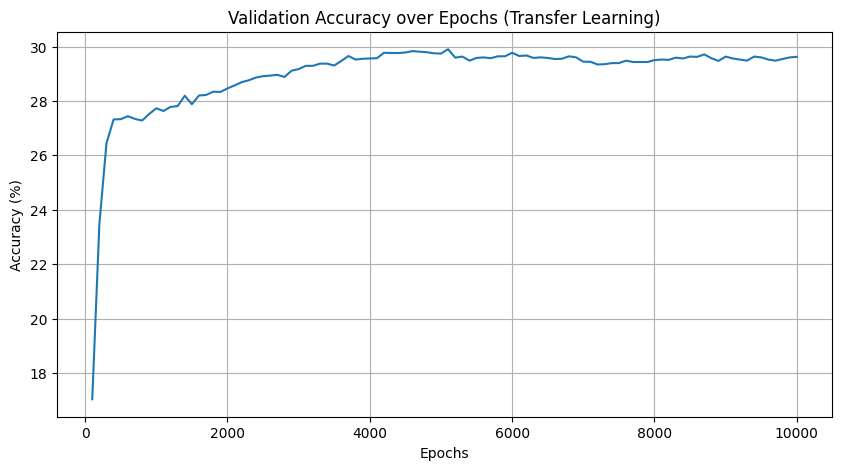

In [64]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(100, num_epochs + 1, 100), finetuning_accuracies)
plt.title('Validation Accuracy over Epochs (Transfer Learning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

In [62]:
# Save the model
torch.save(q4_transfer_learning_model.state_dict(), '/kaggle/working/model/q4_transfer_learning_model.pth')
print('Model saved as q4_transfer_learning_model.pth')

Model saved as q4_transfer_learning_model.pth


### **Comparison**

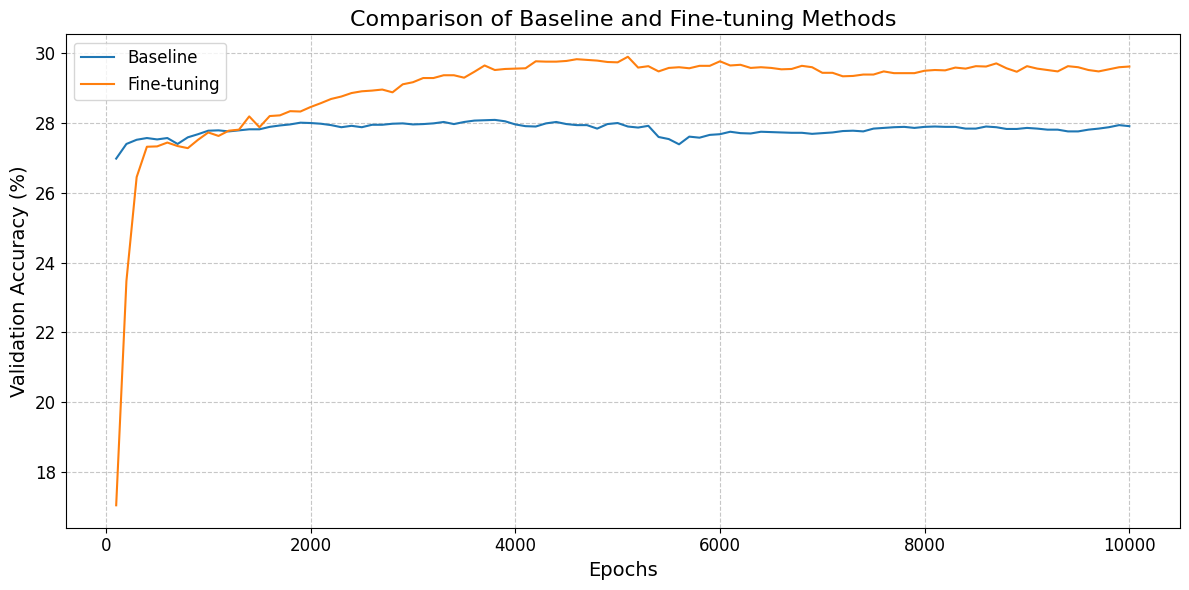

In [65]:
epochs = range(100, 10001, 100)

plt.figure(figsize=(12, 6))
plt.plot(epochs, baseline_accuracies, label='Baseline')
plt.plot(epochs, finetuning_accuracies, label='Fine-tuning')

plt.title('Comparison of Baseline and Fine-tuning Methods', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Accuracy (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()